In [1]:
# https://www.youtube.com/watch?v=TCH_1BHY58I

# Learning to make Makemore by Andrej Karpathy!
# Makemore is a Character Level Language Model
# Treats every input as a sequence of individual characters
# predict next character in the sequence
# 
# Implementing: MLP based on paper "A Neural Probabilistic Language Model" by Bengio et al.

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
# build the dataset

block_size = 3 # how many previous characters do we look at to predict the next one?
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [11]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [13]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80% training
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% validation
Xte, Yte = build_dataset(words[n2:]) # 10% test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [15]:
# lookup table from 27 characters to 2 dimensional space
C = torch.randn((27, 2))
C

tensor([[ 0.5865, -1.9587],
        [ 0.1749,  0.0900],
        [ 0.2334,  0.0422],
        [-1.0334, -1.1787],
        [-0.0426, -0.1574],
        [ 0.5175,  0.6598],
        [-0.2390,  0.8840],
        [-1.0039, -0.8351],
        [-0.1976,  1.3758],
        [ 1.4934, -0.5328],
        [-0.5132,  1.4856],
        [ 1.5445, -0.1973],
        [ 0.4393,  0.3726],
        [ 0.6482, -1.3866],
        [ 1.2321,  0.1708],
        [-0.7637, -0.7442],
        [-0.8613, -0.4573],
        [-0.9891, -1.0555],
        [-1.1252, -0.9324],
        [ 1.4593, -0.2142],
        [ 0.2530,  0.4877],
        [-0.2371, -1.9134],
        [ 0.1015, -0.1132],
        [ 0.9029,  0.2050],
        [-0.9145,  0.8862],
        [ 1.3452, -1.4446],
        [-0.9937, -0.1513]])

In [17]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.5175, 0.6598])

In [19]:
# embedding inputs to random lookup C
emb = C[X]

In [21]:
# constructing hidden layer
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [27]:
h = emb.view(-1, 6) @ W1 + b1 # same as emb.view(32, 6) as python can infer what is happening
# same bias vector is added to the rows
h = torch.tanh(h) # squash between -1 and 1
h.shape

torch.Size([228146, 100])

In [29]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [31]:
logits = h @ W2 + b2

In [33]:
# softmax
counts = logits.exp() # exponentiate
prob = counts / counts.sum(1, keepdims=True) # normalize

In [35]:
loss = -prob[torch.arange(32), Y].log().mean() # negative logarithm loss
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [37]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # lookup table
W1 = torch.randn((30, 200), generator=g) # hidden layer
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) # output layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [39]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [ ]:
lri = []
lossi = []
stepi = []

for p in parameters:
    p.requires_grad = True

for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

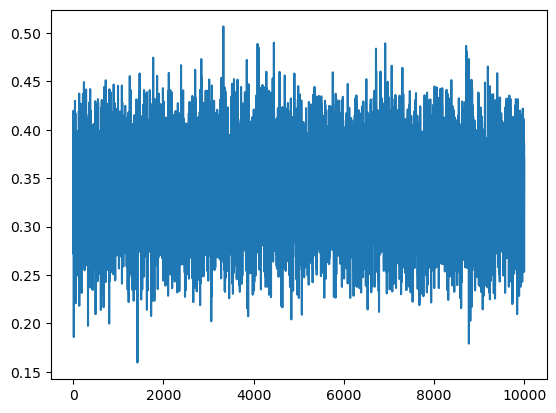

In [78]:
# learning rates versus losses
plt.plot(stepi, lossi)

In [79]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2181, grad_fn=<NllLossBackward0>)

In [80]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1965, grad_fn=<NllLossBackward0>)

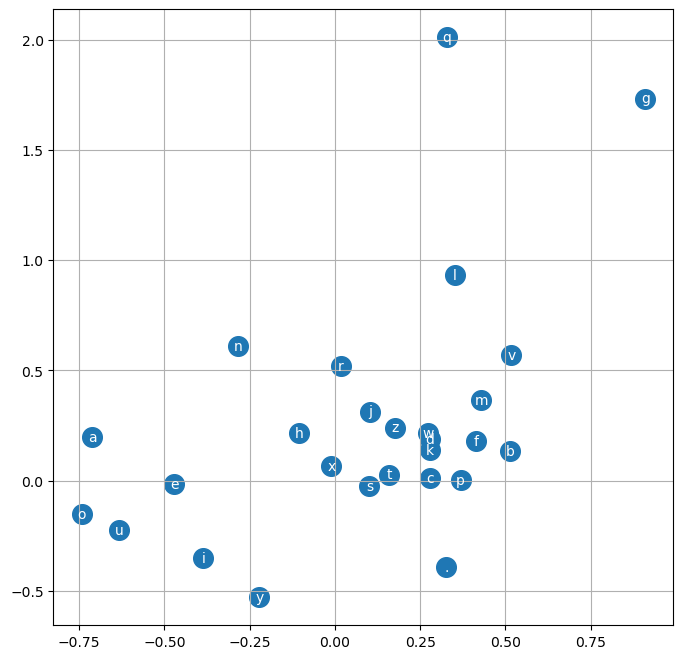

In [295]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [89]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mria.
kayah.
seel.
ndyn.
alarethrettadrlee.
azered.
eliigh.
parelle.
elieana.
ara.
pyriollya.
cayshabergshiriel.
janie.
jelionn.
pulfoutten.
dariyah.
faeha.
kaysh.
samyah.
hil.
